# The notebook is made to parse ad analyse data from AiThinker results for distance measurements from 2 UWB modules

Attention: The filenames should be in the fillowing format: 
1. "min" or "" - to determine the angle direction relative to perpendicular from the baseline of tags
2. anlge - angle between the position of anchor and normal to baseline of tags
3. "deg" if angle units is degrees
4. distance between tags
5. Optional - u can write everything you wand at the end of filename

The file naming example "min_30_deg_10.9090_mybeloved1231.txt".

In [1]:
import numpy as np
import scipy as sp
import pandas as pd

In [2]:
def read_file_data(filename: str, min_num_of_measurements=10) -> pd.DataFrame:
    file = open(filename, mode='r', encoding='utf-8-sig')
    lines = file.readlines()
    file.close()
    # initialize a dictionary for all results to remember the tag and number of measurement
    dict_of_results = {}
    i = 0
    dict_blocks = {}

    for line in lines:
        # clear all garbage lines from the file
        if not line in ['\r\n', '\n', 'hello dwm1000!\n', 'init pass!\n', 'ERROR\n', 'AIT-BU01-DB V100 T2020-5-17\n',
                        'device:TAG ID:0\n']:
            # Use the "OK" line as splitter for data 
            if 'OK' in line:
                # check did we collect any useful data before the "OK" line
                if dict_blocks:
                    name = list(dict_blocks.keys())[0]
                    # check is there a minimal number of measurements made before "OK" line
                    if len(dict_blocks[name]) >= min_num_of_measurements:
                        # copy all collected data into new item of the main dictionary
                        dict_of_results[i] = dict_blocks.copy()
                        # update number of collected measurements
                        i += 1
                    # clear the collecter to push data from new measurements
                    dict_blocks.clear()

            else:
                # split the name of tag and its results
                line = line.split(':')
                # delete m in all lines
                line = [i.strip().replace('m', '') for i in line]
                # check is the did we just clear collecter or there is something and check is the line in the right format 
                if not line[0] in dict_blocks and len(line) > 1:
                    dict_blocks[line[0]] = [float(line[1])]
                else:
                    dict_blocks[line[0]].append(float(line[1]))

    # write all data into DataFrame                
    df_or_results = pd.DataFrame.from_dict(dict_of_results, orient="index")
    return df_or_results


def get_array_from_df(dictionary, n_values_to_drop=5):
    np_array = dictionary.to_numpy()
    index = range(n_values_to_drop - 1)
    return [[np.delete(np.array(i), index), np.delete(np.array(j), index)] for i, j in np_array]

In [3]:

def calc_precision(x: np.array):
    return np.std(x)


def calc_dist_to_tags(dist: float, tr_angle: float, dist_btw_tags: float, in_degrees=True) -> list[float]:
    """
                ^
               /|\
      tr_side1/ | \tr_side2
             /  |d \
            /___|)__\
       l_tag  a ^    r_tag
                | mid_point_btw_tags
    :param dist: d
    :param tr_angle:
    :param dist_btw_tags:
    :param in_degrees: boolean, as default - True
    :return: tr_sides
    """

    if in_degrees:
        tr_angle = tr_angle * np.pi / 180
    # midpoint btw tags
    a = dist_btw_tags / 2

    # just a cosine law
    tr_side2 = np.sqrt(a ** 2 + dist ** 2 - 2 * a * dist * np.cos(tr_angle))
    tr_side1 = np.sqrt(a ** 2 + dist ** 2 - 2 * a * dist * np.cos(np.pi - tr_angle))

    return tr_side1, tr_side2


def calc_RMSE(x: np.ndarray, x_real: float) -> float:
    diff = x - x_real
    return np.sqrt(sum([diff[i] ** 2 for i in range(diff.shape[0])]) / diff.shape[0])

In [4]:
def calc_results(filename: str, array_of_results: np.ndarray, dictionary: dict = None, block_size: float = 0.6):
    # read data from the filename.
    filename = filename.split('/')[1]
    exp_info = filename.split("_")[:-2]
    angl_in_positive = 1
    if exp_info[0] == "min":
        angl_in_positive = -1
        exp_info.pop(0)
    angle, angle_units, dist = [f"{i} " for i in exp_info]
    print(f"Exp info:\n\tAndle\tDistance btw tags (cm)\n\t{angle}{angle_units}\t{dist}")
    angle = np.pi / 2 - float(angle) * np.pi / 180 * angl_in_positive
    dist = float(dist) / 100

    return_dict = False
    if dictionary is not None:
        return_dict = True
        if not dist in dictionary:
            dictionary[dist] = {}

    for n_block in range(len(array_of_results)):
        real_dist_to_anchor = block_size * (n_block + 2) * np.sin(angle)
        truth_dist_to_tags = calc_dist_to_tags(dist=real_dist_to_anchor,
                                               tr_angle=angle, dist_btw_tags=dist, in_degrees=False)

        print(f"\tResults for {real_dist_to_anchor} m:")

        if return_dict:
            if not f'dist_to_anchor {real_dist_to_anchor}' in dictionary[dist]:
                dictionary[dist][f'dist_to_anchor {real_dist_to_anchor}'] = {}
            dictionary[dist][f'dist_to_anchor {real_dist_to_anchor}'][angle] = {}

        for n_tag in range(len(array_of_results[n_block])):
            rmse = calc_RMSE(array_of_results[n_block][n_tag], truth_dist_to_tags[n_tag])
            std = calc_precision(array_of_results[n_block][n_tag])
            estimated_val = np.mean(array_of_results[n_block][n_tag])

            print(f"\tTag {n_tag + 1}")
            print(f"\t\tTrue dist:\t\t\t{truth_dist_to_tags[n_tag]} m")
            print(f"\t\tEstimated dist:\t{estimated_val} m ")
            print(f"\t\tStandard deviation:\t{std * 100} cm")
            print(f"\t\tRMSE of measurement:\t{rmse} m")

            if return_dict:
                dictionary[dist][f'dist_to_anchor {real_dist_to_anchor}'][angle][f'tag {n_tag}'] = {"RMSE": rmse,
                                                                                                    "STD": std,
                                                                                                    "Estimated_val": estimated_val,
                                                                                                    "Truth_dist":
                                                                                                        truth_dist_to_tags[
                                                                                                            n_tag]}
    return dictionary

In [5]:
import os

# Get the list of all files and directories
path = "2_tags_1_anchor_measurements"
dir_list = os.listdir(path)
dictionary = {}
for file_name in dir_list:
    file_name = path + '/' + file_name
    df_of_results = read_file_data(file_name, min_num_of_measurements=40)
    # print(df_of_results)
    results = get_array_from_df(df_of_results)
    dictionary = calc_results(file_name, results, dictionary=dictionary)

Exp info:
	Andle	Distance btw tags (cm)
	45 deg 	60 
	Results for 0.848528137423857 m:
	Tag 1
		True dist:			0.6708203932499369 m
		Estimated dist:	0.9014545454545453 m 
		Standard deviation:	0.6719897677300488 cm
		RMSE of measurement:	0.23073202895985626 m
	Tag 2
		True dist:			1.0816653826391966 m
		Estimated dist:	1.2646296296296295 m 
		Standard deviation:	1.7817278646901862 cm
		RMSE of measurement:	0.18382973397999983 m
	Results for 1.2727922061357855 m:
	Tag 1
		True dist:			1.0816653826391966 m
		Estimated dist:	1.8841304347826084 m 
		Standard deviation:	11.64619005989311 cm
		RMSE of measurement:	0.8108720825152659 m
	Tag 2
		True dist:			1.5 m
		Estimated dist:	2.106521739130435 m 
		Standard deviation:	3.2115104891512014 cm
		RMSE of measurement:	0.6073713855624087 m
	Results for 1.697056274847714 m:
	Tag 1
		True dist:			1.5 m
		Estimated dist:	4.067083333333334 m 
		Standard deviation:	69.20439483073953 cm
		RMSE of measurement:	2.6587293330962942 m
	Tag 2
		True dist:		

In [61]:
max_err = max([tags_info["RMSE"] for dist, value in dictionary.items()
               for anchor_dist, value1 in value.items()
               for angle, value2 in value1.items()
               for tag, tags_info in value2.items()])





0.6920439483073954

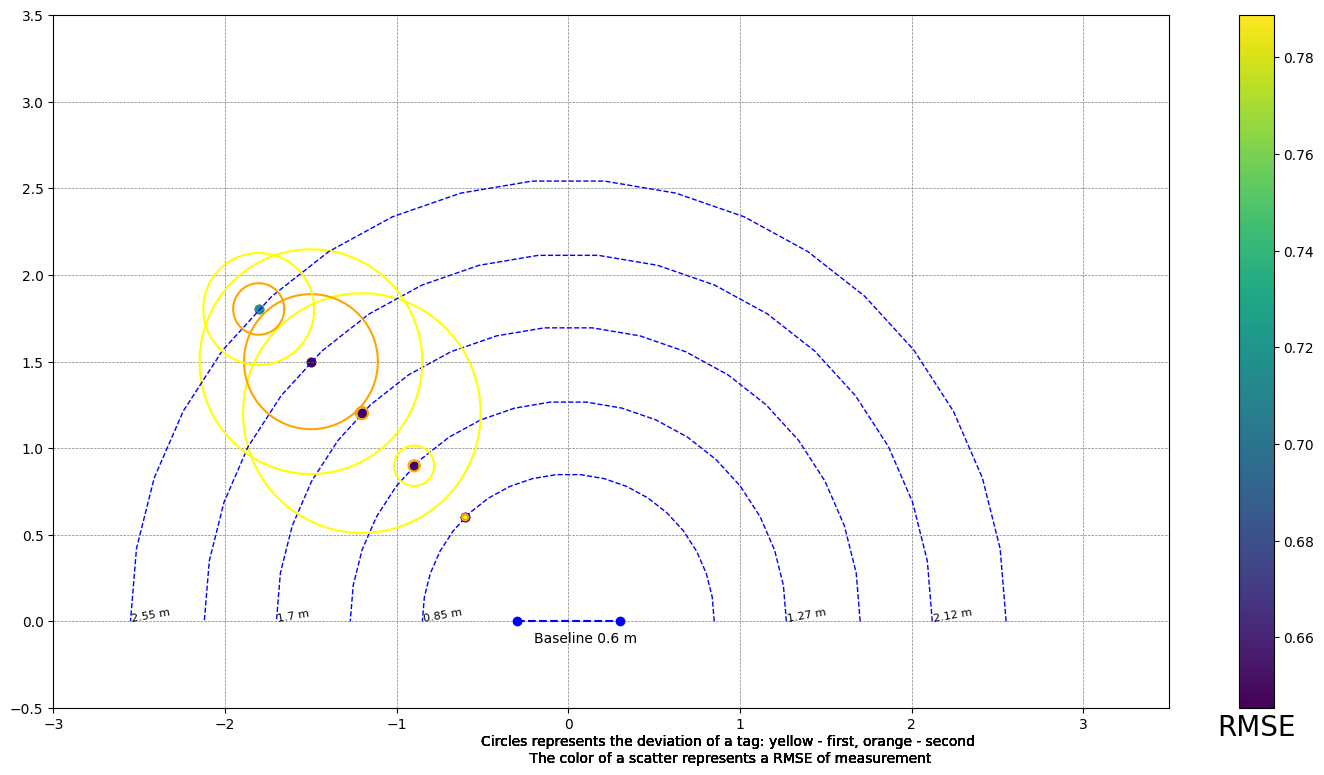

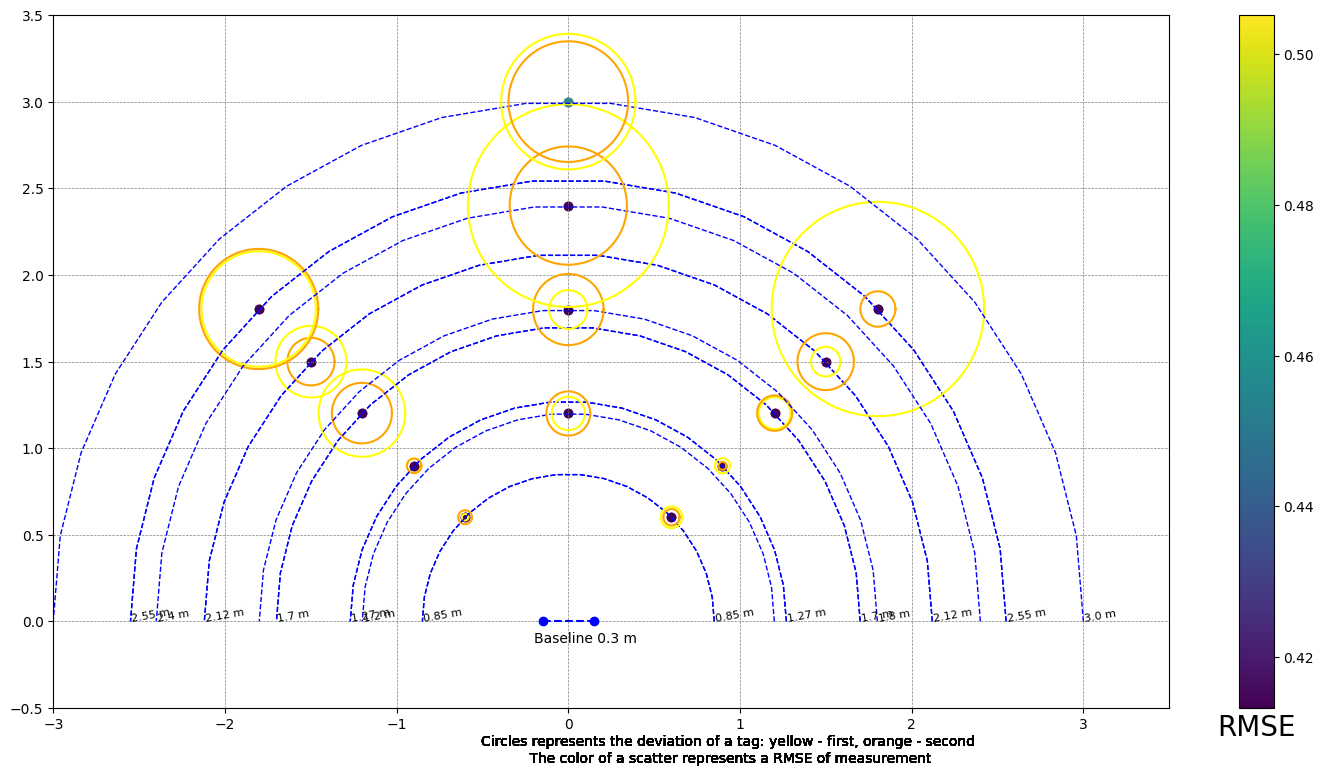

In [74]:
from matplotlib import cm
import matplotlib.pyplot as plt
import matplotlib.colors as clrs

mid_baseline_xy = [0, 0]
for dist, value in dictionary.items():
    fig, ax = plt.subplots(figsize=(18, 9))
    plt.grid(color='gray', linestyle='--', linewidth=0.5)

    left_tag = [mid_baseline_xy[0] - dist / 2, mid_baseline_xy[1]]
    right_tag = [mid_baseline_xy[0] + dist / 2, mid_baseline_xy[1]]
    # plt.plot(mid_baseline_xy[0], mid_baseline_xy[1], marker="o", markersize=20, markeredgecolor="red",
    #          markerfacecolor="green")
    # plt.plot(left_tag[0], left_tag[1], marker="o", markersize=10, markeredgecolor="blue")
    # plt.plot(right_tag[0], right_tag[1], marker="o", markersize=10, markeredgecolor="blue")
    # draw baseline
    plt.plot([left_tag[0], right_tag[0]], [left_tag[1], right_tag[1]], 'bo', linestyle="--")
    plt.gca().annotate(f'Baseline {dist} m', xy=(0 - 0.2, 0 - 0.12), xycoords='data', fontsize=10)

    # plt.text(left_tag[0] - 0.5, left_tag[1] + 0.25, "left_tag")
    # plt.text(right_tag[0], right_tag[1] + 0.25, "right_tag")

    i = 0
    scatters = []
    for anchor_dist, value1 in value.items():
        r = round(float(anchor_dist.split(" ")[1]), 2)
        #draw arc
        arc_angles = np.linspace(0 * np.pi, np.pi, 20)
        arc_xs = r * np.cos(arc_angles)
        arc_ys = r * np.sin(arc_angles)
        plt.plot(arc_xs, arc_ys, linestyle="--", color='blue', lw=1)
        xy = (arc_xs[0], arc_ys[0])
        if i % 2 == 0:
            xy = (arc_xs[-1], arc_ys[0])
        plt.gca().annotate(f'{r} m', xy=xy, xycoords='data', fontsize=8, rotation=10)
        i += 1

        for angle, value2 in value1.items():
            anchor_pose_x = r * np.cos(angle)
            anchor_pose_y = r * np.sin(angle)
            colors = ["yellow", "orange"]
            for tag, tags_info in value2.items():
                tag_n = int(tag.split(' ')[1])
                dr = tags_info["STD"]
                rmse = tags_info["RMSE"]
                est = tags_info["Estimated_val"]
                angles = np.linspace(0 * np.pi, 2 * np.pi, 100)

                # tag_pos = (anchor_pose_x + anchor_pose_x*0.05*(-1)**(tag_n%2), anchor_pose_y)

                # Show std of a tag
                xs = anchor_pose_x + dr * np.cos(angles)
                ys = anchor_pose_y + dr * np.sin(angles)
                plt.plot(xs, ys, color=colors[tag_n])
                plt.scatter(anchor_pose_x, anchor_pose_y, c=rmse/max_err, cmap='viridis')

                # Show the results for each tag
                # est_x = est * np.cos(angle)
                # est_y = est * np.sin(angle)
                # plt.scatter(est_x, est_y, c=colors[tag_n])
                # plt.gca().annotate(f'tag_{tag_n+1}', xy=(est_x, est_y), xycoords='data', fontsize=8, rotation=10)

        txt = "Circles represents the deviation of a tag: yellow - first, orange - second\n The color of a scatter represents a RMSE of measurement"
        fig.text(.5, .05, txt, ha='center')
    cbar = plt.colorbar()
    cbar.ax.set_xlabel('RMSE', fontsize=20)

    plt.xlim(-3, 3.5)
    plt.ylim(-0.5, 3.5)
    plt.show()